In [23]:
import healpy as hp
import lunarsky
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel2016
import pyradiosky
import pyuvdata
import numpy as np
import uvtools

## Load 21cm models

In [24]:
# def z_to_nu(z):
#     nu_0 = 1420405751.768  # Hz
#     return nu_0 / (z+1)

# redshifts = np.loadtxt('z_EIGSEP.txt')
# freqs_models = z_to_nu(redshifts) / 1e9  # GHz
# models = np.loadtxt('T21_EIGSEP.txt') / 1e3  # mK to K

# freqs_models = freqs_models[::-1]
# models = models[:, ::-1]

In [25]:
# # load standard models
# ares_models = np.load('models_21cm.npz')
# ares_T21 = ares_models['models'] / 1e3  # mK to K
# ares_freqs = ares_models['freqs']

## Import Beams

In [26]:
uvb_path = "../luseesky/uvbeams/003/"
fname = "RadiatedElectricField_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_Phase+0deg.uvbeam"

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(uvb_path + fname)

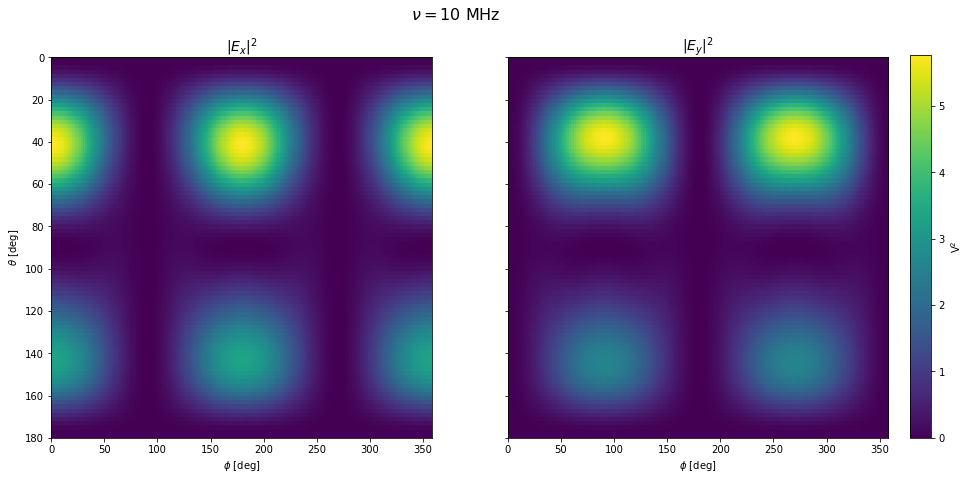

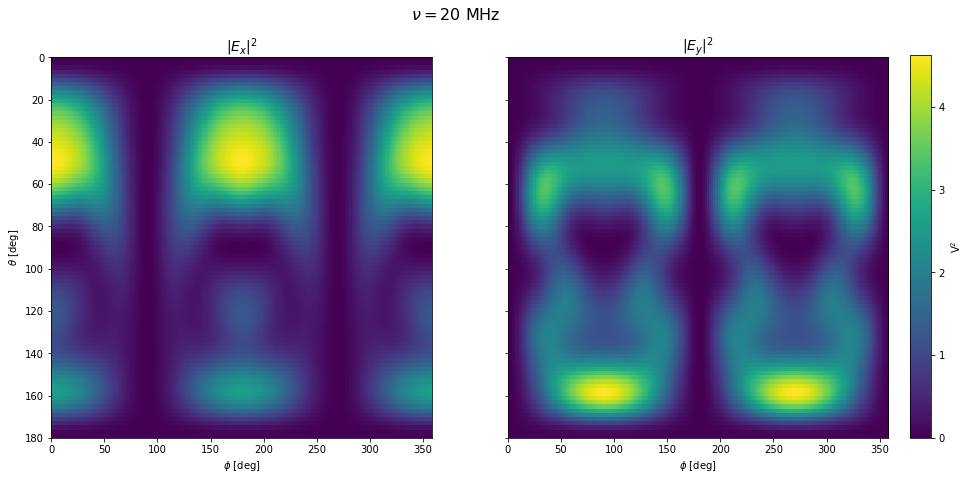

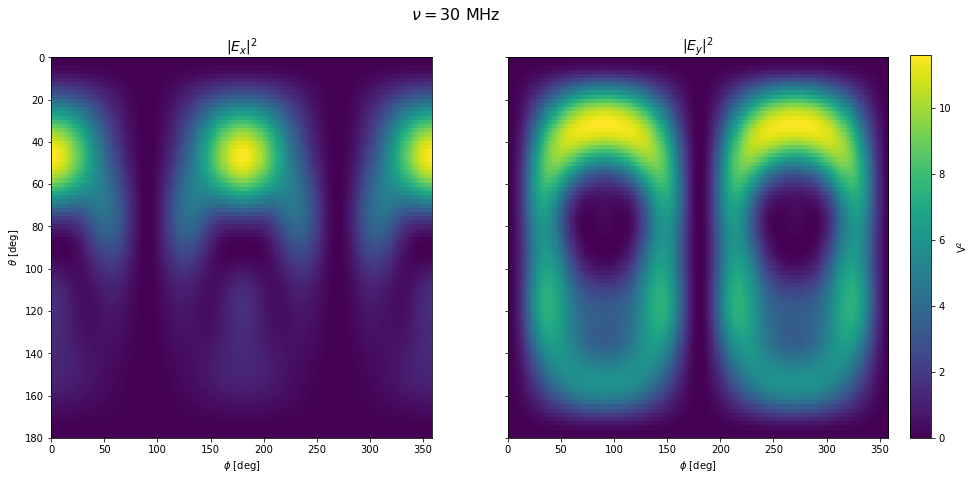

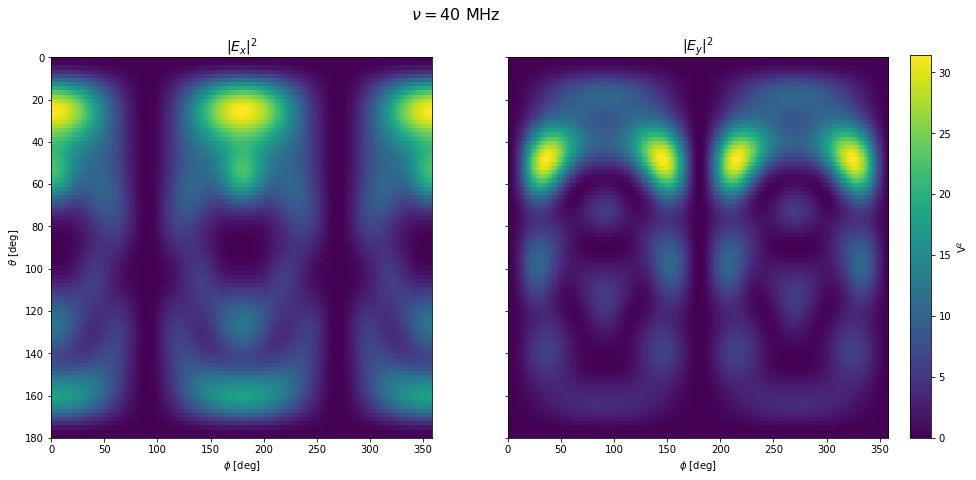

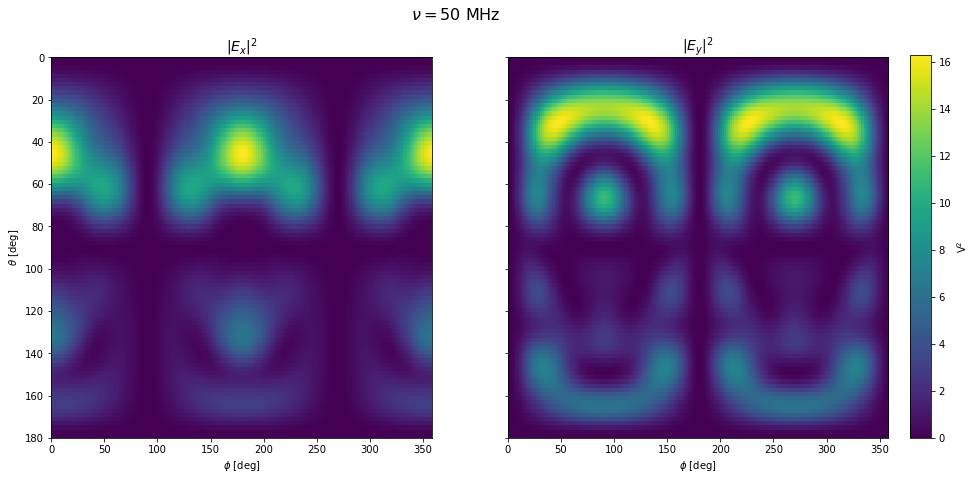

In [27]:
left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
extent = [left, right, bottom, top]
components = ["$|E_x|^2$", "$|E_y|^2$"]

for freq in [10, 20, 30, 40, 50]:
    find = np.argmin(np.abs(uvb.freq_array[0] - freq*1e6))
    fig, axs = plt.subplots(figsize=(15,7), ncols=2, sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        im = ax.imshow(np.abs(uvb.data_array[i, 0, i, find])**2, interpolation="none", aspect="auto", extent=extent)
        ax.set_xlabel("$\\phi$ [deg]")
        if i == 0:
            ax.set_ylabel("$\\theta$ [deg]")
        ax.set_title(components[i], fontsize=14)
    cax=fig.add_axes([0.92, 0.125, .02, .76])
    plt.colorbar(im, cax, label="$\\rm{V}^2$")
    plt.suptitle('$\\nu={:.0f}$ MHz'.format(uvb.freq_array[0, find]/1e6), fontsize=16)
    plt.show()

## Load skymodel

invalid value encountered in log2


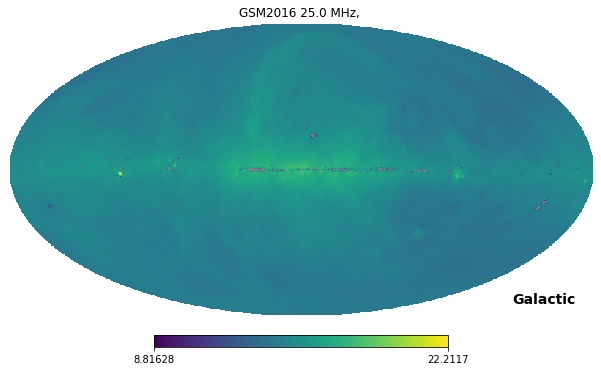

In [28]:
REF_FREQ = 25  # MHz
gsm = GlobalSkyModel2016(freq_unit='MHz')
gsm.generate(REF_FREQ)
gsm.view(logged=True)  # calling mollview with default components, nest=False

In [29]:
# the actual sky model used after filtering
skymodel = pyradiosky.SkyModel()
skymodel.read_text_catalog("../luseesky/skymodels/pygdsm16_srcs.txt")

In [41]:
skymodel.stokes[0,0].shape

(50,)

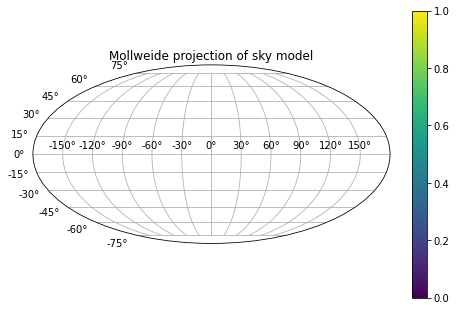

In [60]:
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="mollweide")
plt.title("Mollweide projection of sky model")
plt.grid(True)
plt.scatter(skymodel.ra.rad, skymodel.dec.rad)#, c=skymodel.stokes[0, 0].value)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.colorbar()
plt.show()

## Load UVSim Results

In [110]:
uvdata = np.load("../results/results.npz")
vis = uvdata["data"]
freq = uvdata["freq"]
lst_arr = uvdata["lst"]

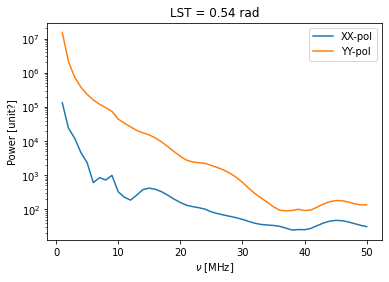

In [111]:
plt.figure()
plt.plot(freq/1e6, vis[0, :, 0], label="XX-pol")
plt.plot(freq/1e6, vis[0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Power [unit?]")
plt.title("LST = {:.2f} rad".format(lst_arr[0]))
plt.yscale("log")
plt.show()

In [112]:
# nonzero after
vis = vis[:1627]
lst_arr = lst_arr[:1627]

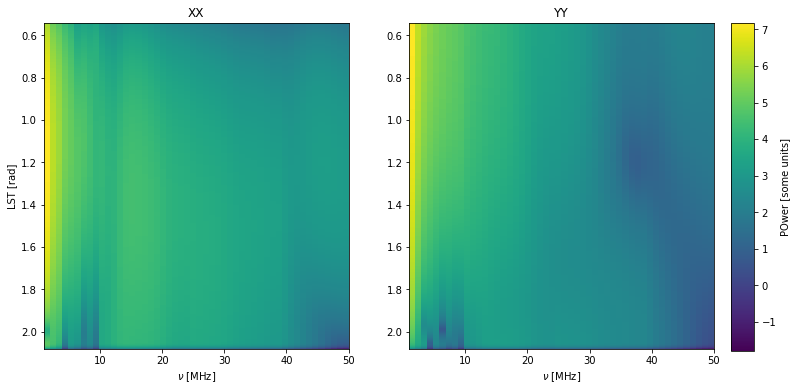

In [113]:
extent = [freq.min()/1e6, freq.max()/1e6, lst_arr.max(), lst_arr.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 0]), mode='real', extent=extent)
#im.set_clim(0, 0.45)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 1]), mode='real', extent=extent)
#im.set_clim(0, 0.45)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="POwer [some units]")

## Compute eigenmodes

In [114]:
pols = ["XX", "YY"]

idata = vis[:, :, :2]  # uncalibrated, nspws=0, no crosspols
d = idata - np.mean(idata, axis=0)  # subtract mean in time

V_full = np.empty((freq.size, freq.size, 2)) # eigenvector change of basis
for i, _ in enumerate(pols):  # compute for both XX and YY
    C = np.dot(d[:, :, i].T, d[:, :, i])  # covariance matrix
    U, S, V = np.linalg.svd(C)
    V_full[:, :, i] = V 

In [123]:
np.abs(V_full[:, :, 0] @ idata[i, :, 0])

array([1.35771436e+05, 3.87407165e+03, 2.27177796e+03, 8.33039724e+02,
       4.28963272e+02, 6.33991779e+02, 1.05259633e+02, 2.12745285e+01,
       3.10104076e+00, 1.17293868e+00, 1.78353852e+00, 5.23519484e-01,
       6.41435897e-02, 7.51378413e-03, 2.17447662e-02, 2.52190432e-02,
       5.35158968e-03, 1.16415475e-03, 9.73342111e-03, 2.25903495e-03,
       5.31035886e-03, 3.03978172e-03, 7.63538948e-04, 4.09910006e-04,
       3.07095754e-03, 4.26333646e-05, 1.18889065e-03, 7.30902551e-04,
       3.90359540e-04, 2.08443534e-04, 2.28260379e-05, 6.41269966e-04,
       5.38862325e-04, 7.69071631e-04, 3.06556574e-04, 1.29703865e-04,
       2.45538517e-04, 1.23411017e-04, 2.23446027e-05, 6.33562413e-05,
       9.04938601e-05, 9.64361134e-05, 8.92495261e-05, 2.58536128e-05,
       2.48238242e-05, 4.08713475e-05, 3.02641294e-06, 4.15847609e-05,
       6.57490134e-03, 1.84973768e-03])

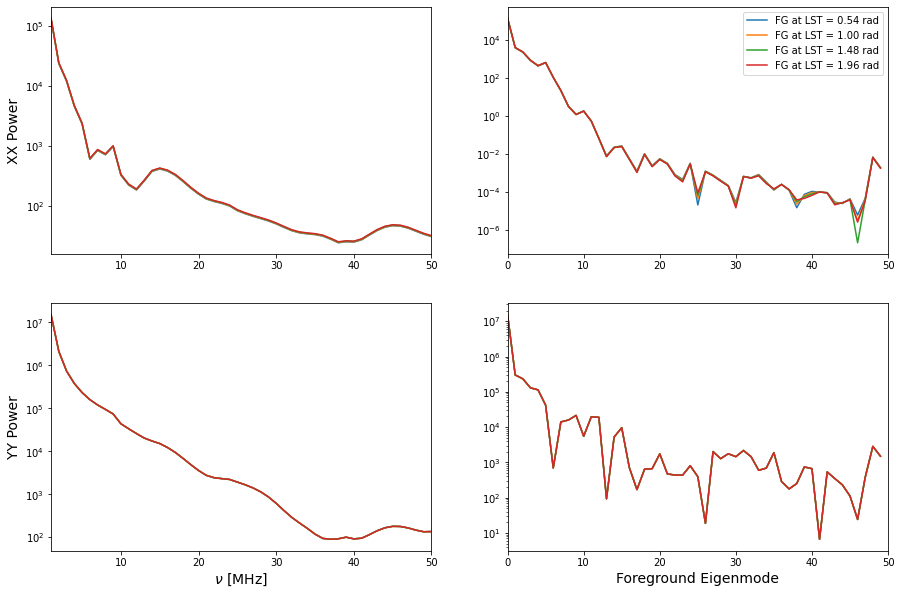

In [124]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

for i, lst in enumerate(lst_arr[::500]):
    axs[0, 0].plot(freq/1e6, np.abs(idata[i, :, 0]), label="FG at LST = {:.2f} rad".format(lst))
    axs[0, 1].plot(np.abs(V_full[:, :, 0] @ idata[i, :, 0]), label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 0].plot(freq/1e6, np.abs(idata[i, :, 1]), label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 1].plot(np.abs(V_full[:, :, 0] @ idata[0, :, 1]), label="FG at LST = {:.2f} rad".format(lst))

plt.setp(axs[:, 0], yscale="symlog", xlim=(freq.min()/1e6, freq.max()/1e6))
plt.setp(axs[:, 1], yscale="log", xlim=(0, len(V_full)))
axs[1, 0].set_xlabel("$\\nu$ [MHz]", fontsize=14)
axs[1, 1].set_xlabel("Foreground Eigenmode", fontsize=14)
for i, pol in enumerate(pols):
    axs[i, 0].set_ylabel(f"{pol} Power", fontsize=14)
axs[0, 1].legend()

plt.show()